In [1]:
import pathlib

import numpy as np
import pandas as pd

import datetime as dt

import itertools

import holidays_co

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn import metrics

from sklearn import preprocessing
from sklearn.pipeline import Pipeline

# from sklearnex import patch_sklearn
# patch_sklearn()

from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

from sklearn.inspection import permutation_importance

from joblib import dump, load

# Datos

In [41]:
data = pd.read_csv('./data/processed/dataset.csv', index_col=0)
data.index = pd.to_datetime(data.index)

data = data.drop(columns=['value_no_cl',])

pd.set_option('display.float_format', lambda x: '%.5f' % x)

## Datos para entrenamiento, prueba y validación

In [42]:
X = data.drop(columns='value')
y = data.loc[:, ['value']]

X_train = X.loc['2012-01-01':'2016-06-30']
y_train = y.loc['2012-01-01':'2016-06-30']

X_val = X.loc['2017-01-01':'2017-12-31']
y_val = y.loc['2017-01-01':'2017-12-31']

X_test = X.loc['2018-01-01':'2018-06-30']

scaler_y = preprocessing.RobustScaler(with_centering=False, quantile_range=(0, 99)).fit(y_train)
print(scaler_y.center_)
print(scaler_y.scale_)

y_train_scaled = pd.DataFrame(
    data=scaler_y.transform(y_train),
    index=y_train.index, columns=y_train.columns
)

y_val_scaled = pd.DataFrame(
    data=scaler_y.transform(y_val),
    index=y_val.index, columns=y_val.columns
)

y_scaled = pd.DataFrame(
    data=scaler_y.transform(y),
    index=y.index, columns=y.columns
)


None
[2059.06]


## Evaluación modelos

In [43]:
# models_dict = {
#     'Ridge': None,
#     'Lasso': None,
#     'ElasticNet': None,
#     'SVR': None,
#     'KNeighborsRegressor': None,
#     'RandomForestRegressor': None,
#     'GradientBoostingRegressor': None
# }

models_dict = {
    'Ridge': {
        'estimator': Ridge(),
        'best_estimator': None,
        },
    'Lasso': {
        'estimator': Lasso(),
        'best_estimator': None,
    },
    'ElasticNet': {
        'estimator': ElasticNet(),
        'best_estimator': None,
    },
    'KNeighborsRegressor': {
        'estimator': KNeighborsRegressor(),
        'best_estimator': None,
    },
    'RandomForestRegressor': {
        'estimator': RandomForestRegressor(
            oob_score=False,
            random_state=123,
        ),
        'best_estimator': None,
    },
    'GradientBoostingRegressor': {
        'estimator': GradientBoostingRegressor(
            n_estimators=1000,
            random_state=123,
            # Activación de la parada temprana
            validation_fraction=0.1,
            n_iter_no_change=5,
            tol=0.0001
        ),
        'best_estimator': None,
    },
    'SVR': {
        'estimator': SVR(),
        'best_estimator': None,
    },
}

In [48]:
df_holydays = pd.DataFrame(columns=['holiday'])

for year in range(2011, 2019):
    holidays = [pd.Timestamp(ii.date) for ii in holidays_co.get_colombia_holidays_by_year(year)]

    for hd in holidays:
        df_holydays.loc[hd, :] = 1

df_y_train_predict = pd.DataFrame(index=y_train.index, columns=models_dict.keys())
df_y_val_predict = pd.DataFrame(index=y_val.index, columns=models_dict.keys())
df_y_test_predict = pd.DataFrame(index=X_test.index, columns=models_dict.keys())

rutas_modelos = list(pathlib.Path('./models/').glob('*.joblib'))

for ruta_modelo in rutas_modelos:

    nombre_modelo = ruta_modelo.stem

    print(f'Cargando modelo {nombre_modelo} ...')

    clf = load(str(ruta_modelo))

    models_dict[nombre_modelo]['best_estimator'] = clf

    print(clf.best_params_)

    y_train_predict = scaler_y.inverse_transform(clf.predict(X_train).reshape(-1, 1))
    y_val_predict = scaler_y.inverse_transform(clf.predict(X_val).reshape(-1, 1))
    y_test_predict = scaler_y.inverse_transform(clf.predict(X_test).reshape(-1, 1))

    df_y_train_predict.loc[:, nombre_modelo] = y_train_predict
    df_y_val_predict.loc[:, nombre_modelo] = y_val_predict
    df_y_test_predict.loc[:, nombre_modelo] = y_test_predict

df_y_train_predict[df_y_train_predict < 0] = 0
df_y_val_predict[df_y_val_predict < 0] = 0
df_y_test_predict[df_y_test_predict < 0] = 0

df_y_train_predict.loc[df_holydays.index.intersection(df_y_train_predict.index)] = 0
df_y_val_predict.loc[df_holydays.index.intersection(df_y_val_predict.index)] = 0
df_y_test_predict.loc[df_holydays.index.intersection(df_y_test_predict.index)] = 0

df_y_train_predict = pd.concat([df_y_train_predict, y_train], axis=1)
df_y_val_predict = pd.concat([df_y_val_predict, y_val], axis=1)
# df_y_test_predict = pd.concat([df_y_test_predict, y_val], axis=1)

df_y_train_predict.to_csv('./outputs/results_train.csv')
df_y_val_predict.to_csv('./outputs/results_val.csv')
df_y_test_predict.to_csv('./outputs/results_test.csv')


Cargando modelo ElasticNet ...
{'estimator__alpha': 0.01, 'estimator__l1_ratio': 0.05, 'pca__n_components': 13}
Cargando modelo KNeighborsRegressor ...
{'estimator__n_neighbors': 7, 'estimator__p': 1, 'estimator__weights': 'distance', 'pca__n_components': 10}
Cargando modelo RandomForestRegressor ...
{'estimator__max_depth': 5, 'estimator__max_features': 'sqrt', 'estimator__n_estimators': 400, 'pca__n_components': 9}
Cargando modelo Lasso ...
{'estimator__alpha': 0.001788649529057435, 'pca__n_components': 13}
Cargando modelo Ridge ...
{'estimator__alpha': 1.747528400007683, 'pca__n_components': 13}
Cargando modelo SVR ...
{'estimator__C': 75, 'estimator__gamma': 0.01, 'estimator__kernel': 'rbf', 'pca__n_components': 12}
Cargando modelo GradientBoostingRegressor ...
{'estimator__learning_rate': 0.1, 'estimator__max_depth': 5, 'estimator__max_features': 'sqrt', 'estimator__subsample': 1, 'pca__n_components': 9}


In [49]:
tuples = list(itertools.product(models_dict.keys(), ['train', 'val',]))
multi_index = pd.MultiIndex.from_tuples(tuples, names=["model", "period"])

df_metrics = pd.DataFrame(columns=multi_index)

for model_str in models_dict.keys():

    tmp_val = df_y_val_predict.loc[:, ['value', model_str]].to_numpy().T

    df_metrics.loc['r2', (model_str, 'val')] = metrics.r2_score(tmp_val[0], tmp_val[1])
    df_metrics.loc['explained_variance', (model_str, 'val')] = metrics.explained_variance_score(tmp_val[0], tmp_val[1])
    df_metrics.loc['max_error', (model_str, 'val')] = metrics.max_error(tmp_val[0], tmp_val[1])
    df_metrics.loc['mean_absolute_error', (model_str, 'val')] = metrics.mean_absolute_error(tmp_val[0], tmp_val[1])
    df_metrics.loc['mean_squared_error', (model_str, 'val')] = metrics.mean_squared_error(tmp_val[0], tmp_val[1])
    df_metrics.loc['root_mean_squared_error', (model_str, 'val')] = metrics.mean_squared_error(tmp_val[0], tmp_val[1], squared=False)


    tmp_train = df_y_train_predict.loc[:, ['value', model_str]].to_numpy().T

    df_metrics.loc['r2', (model_str, 'train')] = metrics.r2_score(tmp_train[0], tmp_train[1])
    df_metrics.loc['explained_variance', (model_str, 'train')] = metrics.explained_variance_score(tmp_train[0], tmp_train[1])
    df_metrics.loc['max_error', (model_str, 'train')] = metrics.max_error(tmp_train[0], tmp_train[1])
    df_metrics.loc['mean_absolute_error', (model_str, 'train')] = metrics.mean_absolute_error(tmp_train[0], tmp_train[1])
    df_metrics.loc['mean_squared_error', (model_str, 'train')] = metrics.mean_squared_error(tmp_train[0], tmp_train[1])
    df_metrics.loc['root_mean_squared_error', (model_str, 'train')] = metrics.mean_squared_error(tmp_train[0], tmp_train[1], squared=False)

df_metrics.T.to_csv('./outputs/metrics.csv')

df_metrics.T

r2 explained_variance  max_error  \
model                     period                                         
Ridge                     train  0.64738            0.64809 2428.41730   
                          val    0.46678            0.46697 2310.26346   
Lasso                     train  0.63912            0.64122 2399.89384   
                          val    0.43651            0.47944 2193.58313   
ElasticNet                train  0.63742            0.63903 2433.49771   
                          val    0.46721            0.48150 2268.86077   
KNeighborsRegressor       train  0.99907            0.99970  111.00000   
                          val    0.51972            0.52859 2079.98859   
RandomForestRegressor     train  0.82898            0.83017 1678.25412   
                          val    0.56199            0.59480 2028.93601   
GradientBoostingRegressor train  0.92028            0.92133  983.55052   
                          val    0.54295            0.54379 2168.32023   
SVR                       train  0.78141            0.78143 2277.77805   
                          val    0.49268            0.53804 2214.40917   

                                 mean_absolute_error mean_squared_error  \
model                     period                                          
Ridge                     train            242.82684       105886.11659   
                          val              249.68660       148869.58499   
Lasso                     train            244.85457       108366.02019   
                          val              287.99121       157321.24772   
ElasticNet                train            245.92250       108874.98012   
                          val              269.62406       148749.71321   
KNeighborsRegressor       train             13.77225          278.74535   
                          val              221.88056       134090.79315   
RandomForestRegressor     train            148.83514        51354.88206   
                          val              235.47956       122287.79673   
GradientBoostingRegressor train             97.83433        23938.31071   
                          val              202.13517       127604.76234   
SVR                       train            173.37306        65638.48625   
                          val              263.56127       141638.33461   

                                 root_mean_squared_error  
model                     period                          
Ridge                     train                325.40147  
                          val                  385.83622  
Lasso                     train                329.18995  
                          val                  396.63743  
ElasticNet                train                329.96209  
                          val                  385.68084  
KNeighborsRegressor       train                 16.69567  
                          val                  366.18410  
RandomForestRegressor     train                226.61616  
                          val                  349.69672  
GradientBoostingRegressor train                154.72010  
                          val                  357.21809  
SVR                       train                256.20009  
                          val                  376.34869

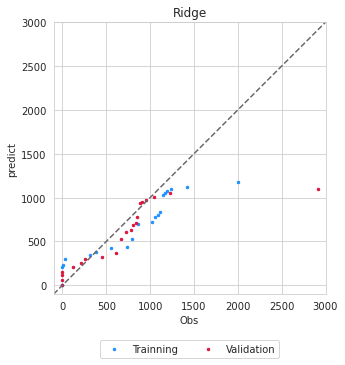

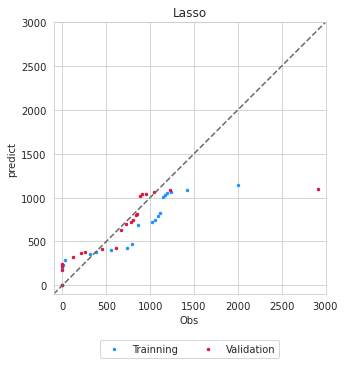

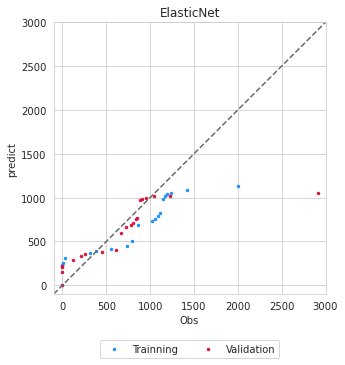

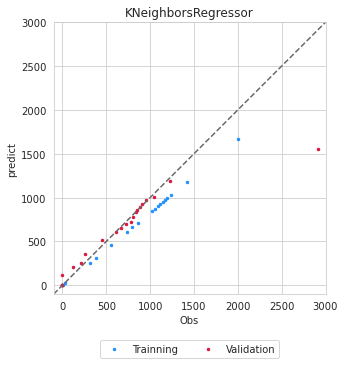

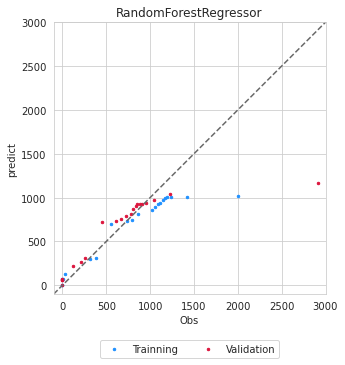

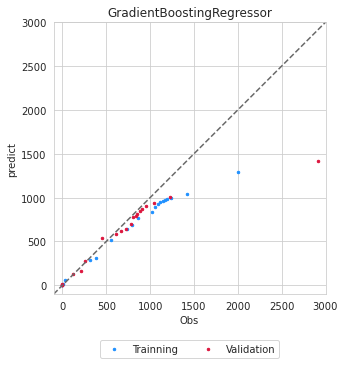

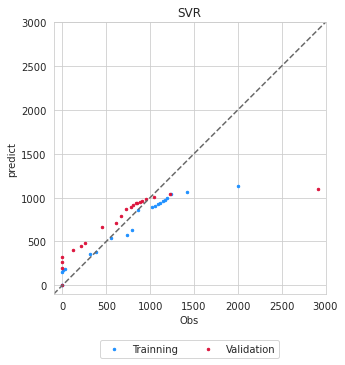

In [40]:
for model_str in models_dict.keys():
    tmp_train_plot = df_y_train_predict.loc[:, ['value', model_str]]
    tmp_train_plot = tmp_train_plot.quantile(np.arange(0, 1.05, 0.05))

    tmp_val_plot = df_y_val_predict.loc[:, ['value', model_str]]
    tmp_val_plot = tmp_val_plot.quantile(np.arange(0, 1.05, 0.05))

    fig, ax = plt.subplots(figsize=(5, 5))
    ax.scatter(
        tmp_train_plot.loc[:, 'value'], tmp_train_plot.loc[:, model_str], s=6,
        label='Trainning', color='dodgerblue'
    )
    ax.scatter(
        tmp_val_plot.loc[:, 'value'], tmp_val_plot.loc[:, model_str], s=6,
        label='Validation', color='crimson'
    )

    ax.set_xlim(-100, 3000)
    ax.set_ylim(-100, 3000)

    x = np.linspace(*ax.get_ylim())
    ax.plot(x, x, '--', color='dimgrey')

    ax.set_title(model_str)
    ax.set_xlabel('Obs')
    ax.set_ylabel('predict')

    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5)
    ax.set_aspect('equal', adjustable='box')
    plt.savefig(f'./figures/qq_{model_str}.png')
    plt.show()
    plt.close(fig)


In [9]:
importancia_predictores = pd.DataFrame(
    models_dict['GradientBoostingRegressor']['best_estimator'].best_estimator_['estimator'].feature_importances_
)
print("Importancia de los predictores en el modelo")
print("-------------------------------------------")
importancia_predictores.sort_values(0, ascending=False)

Importancia de los predictores en el modelo
-------------------------------------------


,0
5,0.32010
4,0.15664
7,0.13080
6,0.08950
3,0.08491
9,0.08254
10,0.04138
2,0.03640
0,0.02789
1,0.02404


In [27]:
import pickle as pk
pca_save = PCA().fit(X_train)
dump(pca_save, str(pathlib.Path('./outputs/pca.joblib')))
# pk.dump(pca_save, open(str(pathlib.Path('./outputs/pca.pk')), 'wb'))

In [34]:
pca = PCA(svd_solver='full')
scaler = preprocessing.RobustScaler(with_centering=False, quantile_range=(0, 99))
pipeline =  Pipeline(steps=[("scaler", scaler), ("pca", pca)]).fit(X_train)
dump(pipeline, str(pathlib.Path('./outputs/pipeline.joblib')))

['outputs/pipeline.joblib']

In [39]:
for model_str in models_dict.keys():
    importancia = permutation_importance(
                    estimator    = models_dict[model_str]['best_estimator'].best_estimator_,
                    X            = X_train,
                    y            = y_train,
                    n_repeats    = 10,
                    scoring      = 'neg_root_mean_squared_error',
                    n_jobs       = 2,
                    random_state = 123
                 )
    df_importancia = pd.DataFrame(
                        {k: importancia[k] for k in ['importances_mean', 'importances_std']}
                     )
    df_importancia['feature'] = X_train.columns
    df_importancia = df_importancia.sort_values('importances_mean', ascending=False)
    df_importancia.to_csv(f'./outputs/importancia_variables_{model_str}.csv')

In [13]:
models_dict.keys()

dict_keys(['Ridge', 'Lasso', 'ElasticNet', 'KNeighborsRegressor', 'RandomForestRegressor', 'GradientBoostingRegressor', 'SVR'])